# Autoencoders


- What are autoencoders?
- Why use them? (Compression, denoising, manifold learning, etc.)
- Autoencoders vs PCA
- Real-world examples (image compression, anomaly detection)


In [4]:
!pip install torch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
def plot_results(model, X, y):
    #Visualize original and reconstructed images
    model.eval()
    with torch.no_grad():
        x_hat, z = model(X)


    # Show original and reconstructed digits using imshow
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        # Original images
        axes[0, i].imshow(X[i].numpy().reshape(8, 8), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed images
        axes[1, i].imshow(x_hat[i].numpy().reshape(8, 8), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    plt.tight_layout()
    plt.show()

    # 5. Visualize the 2D latent space
    plt.figure(figsize=(6, 5))
    z = z.numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y.numpy(), cmap='tab10', alpha=0.7, s=15)
    plt.colorbar(label='Digit Label')
    plt.title("2D Latent Space")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(True)
    plt.show()


In [9]:
torch.manual_seed(42)

# Load and normalize the digits dataset (8x8 grayscale images)
digits = load_digits()
X = digits.data  # shape: (n_samples, 64)
y = digits.target
X = MinMaxScaler().fit_transform(X)  # standardize to range [0,1]
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y)

train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Vanilla Autoencoder
   - A simple autoencoder architecture consisting of an encoder and a decoder, both typically made up of fully connected layers.
   - The encoder compresses the input $ \mathbf{x} \in \mathbb{R}^d $ into a latent representation $ \mathbf{z} \in \mathbb{R}^k $, where $ k < d $. The decoder then reconstructs the input $ \hat{\mathbf{x}} $ from $ \mathbf{z} $.

<img src="./images/Autoencoder_structure.png" alt="isolated" width="500"/>

*Image from https://commons.wikimedia.org/wiki/File:Autoencoder_structure.png*




   **Mathematical Formulation**: the autoencoder learns a function $ \mathrm{Enc}: \mathbb{R}^d \to \mathbb{R}^k $ for encoding and $ \mathrm{Dec}: \mathbb{R}^k \to \mathbb{R}^d $ for decoding.

   **Structure of mappings**
   Compositions of linear maps defined by matrices $\mathbf{A}_i$, Rectified Linear Units
   $$
   \mathrm{ReLU}(x) =\begin{cases} 0 &, x <> 0\\ x & x \geq  0\end{cases},
   $$
   and sigmoid functions $\sigma(x) = \frac{1}{1+e^{-x}}$.

   For example, take 
   * $p=64$ and $k=2$ 
   * $\mathbf{A}_1 \in \mathbb{R}^{32 \times 64}, \mathbf{A}_2 \in \mathbb{R}^{2 \times 32}$, 
   * $\mathbf{B}_1 \in \mathbb{R}^{64 \times 32}, \mathbf{A}_1 \in \mathbb{R}^{32 \times 2}$. 
   
   Then define
   $$
   \mathbf{z} = \mathrm{Enc}(\mathbf{x}) = \mathbf{A}_2\mathrm{ReLU}(\mathbf{A}_1\mathbf{x}).
   $$
   $$
   \mathrm{Dec}(\mathbf{z}) = \sigma(\mathbf{B}_1\mathrm{ReLU}(\mathbf{B}_2\mathbf{z})).
   $$
   Reconstruction
   $$
   \hat{\mathbf{x}} = \mathrm{Dec} \circ \mathrm{Enc} (\mathbf{x})
   $$
   

   The basic loss function minimizes the reconstruction error:
   $$
   L = \frac{1}{p} \sum_{i=1}^{p} \| \mathbf{x}_i - \hat{\mathbf{x}}_i \|^2
   $$
   where $ \mathbf{x}_i $ is the $ i $-th input and $ \hat{\mathbf{x}}_i $ is the reconstructed output.

   Optimize with adaptive learning rate gradient descent called ADAM 
   * original paper https://arxiv.org/pdf/1412.6980
   * tutorial https://www.datacamp.com/tutorial/adam-optimizer-tutorial



In [10]:
#Define a small autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),  # 2D latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid()  # because inputs are in [0, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


Epoch 0, Loss: 4.27
Epoch 10, Loss: 1.91
Epoch 20, Loss: 1.69
Epoch 30, Loss: 1.53
Epoch 40, Loss: 1.40
Epoch 50, Loss: 1.34
Epoch 60, Loss: 1.30
Epoch 70, Loss: 1.28
Epoch 80, Loss: 1.26
Epoch 90, Loss: 1.23
Epoch 100, Loss: 1.22
Epoch 110, Loss: 1.19
Epoch 120, Loss: 1.19
Epoch 130, Loss: 1.16
Epoch 140, Loss: 1.16
Epoch 150, Loss: 1.15
Epoch 160, Loss: 1.15
Epoch 170, Loss: 1.14
Epoch 180, Loss: 1.14
Epoch 190, Loss: 1.13


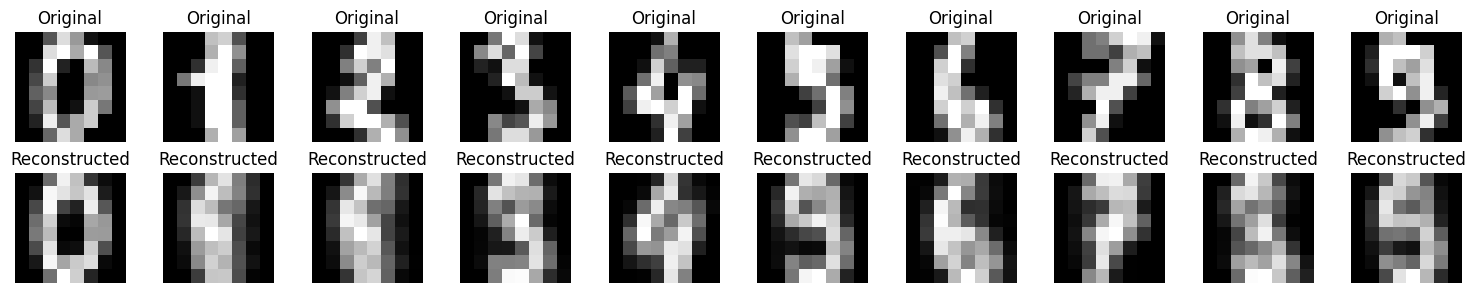

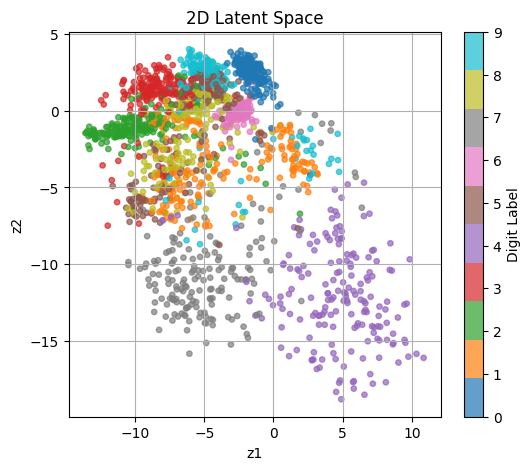

In [12]:
torch.manual_seed(1)

model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

for epoch in range(200):
    total_loss = 0
    for x_batch, _ in train_loader:
        x_hat, _ = model(x_batch)
        loss = nn.functional.mse_loss(x_hat, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.2f}")
        
plot_results(model, X, y)


### Denoising Autoencoder

Trained by adding noise to the input and requiring the network to recover the original, clean input.

**Mathematical Formulation**: Given a noisy input $ \tilde{\mathbf{x}}_i = \mathbf{x}_i + \epsilon $, where $ \epsilon $ is random noise, the goal is to minimize the reconstruction error between the reconstruction $ \hat{\mathbf{x}}_i $ and the clean data $ \mathbf{x}_i $:
   $$
   L = \frac{1}{p} \sum_{i=1}^{p} \| \mathbf{x}_i - \hat{\mathbf{x}}_i \|^2
   $$
   where **$ \hat{\mathbf{x}}_i $ is the reconstruction from the noisy input $ \tilde{\mathbf{x}}_i $.**


Epoch 0, Loss: 4.27
Epoch 10, Loss: 1.89
Epoch 20, Loss: 1.70
Epoch 30, Loss: 1.53
Epoch 40, Loss: 1.40
Epoch 50, Loss: 1.35
Epoch 60, Loss: 1.32
Epoch 70, Loss: 1.29
Epoch 80, Loss: 1.27
Epoch 90, Loss: 1.25
Epoch 100, Loss: 1.25
Epoch 110, Loss: 1.22
Epoch 120, Loss: 1.21
Epoch 130, Loss: 1.20
Epoch 140, Loss: 1.19
Epoch 150, Loss: 1.14
Epoch 160, Loss: 1.14
Epoch 170, Loss: 1.14
Epoch 180, Loss: 1.12
Epoch 190, Loss: 1.11


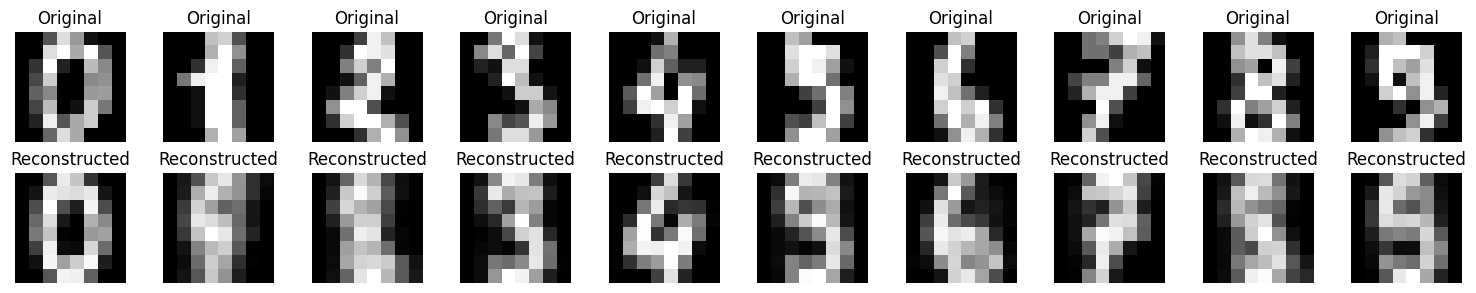

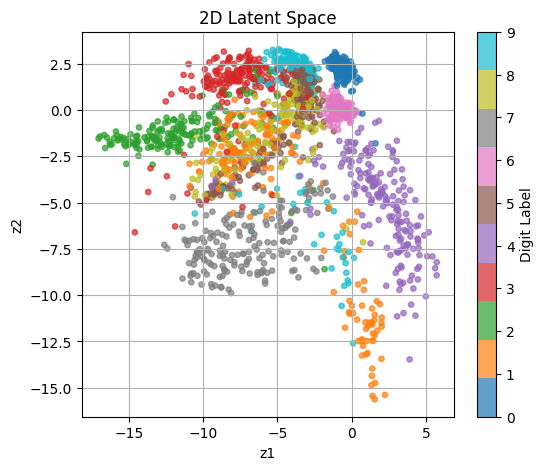

In [13]:
torch.manual_seed(1)

model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# 3. Train the autoencoder
for epoch in range(200):
    total_loss = 0
    for x_batch, _ in train_loader:

        # Add Gaussian noise to x_batch
        noise = torch.randn_like(x_batch) * 0.1  # Adjust the scale of noise as needed
        x_batch_noisy = x_batch + noise

        x_hat, _ = model(x_batch_noisy)
        loss = nn.functional.mse_loss(x_hat, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.2f}")

plot_results(model, X, y)

### Variational Autoencoder (VAE)
   - A probabilistic variant of the autoencoder, where the encoder outputs parameters for a probability distribution (mean and variance), and the latent space is sampled from this distribution.
   - The decoder reconstructs the input from the latent variable sampled from the distribution.
   - **Mathematical Formulation**: For each input $ \mathbf{x}_i $, the encoder learns the parameters $ \mu(\mathbf{x}_i) $ and $ \sigma(\mathbf{x}_i) $ for the normal distribution:
   $$
   q(z|x_i) = \mathcal{N}(z_i | \mu(\mathbf{x}_i), \sigma(\mathbf{x}_i)^2)
   $$
   The decoder then reconstructs the input:
   $$
   p(\hat{x}_i | z_i) = \mathcal{N}(\hat{\mathbf{x}}_i | f(z_i), \sigma^2)
   $$
   The VAE loss function combines the reconstruction error and the Kullback-Leibler divergence between the learned distribution and a prior distribution:
   $$
   L_{\text{VAE}} = \frac{1}{p} \sum_{i=1}^{p} \mathrm{BCE} (\mathbf{x}_i - \hat{\mathbf{x}}_i)+ \text{KL}[q(z|x_i) \| p(z)]
   $$
   where $ p(z) $ is a prior distribution (often standard normal).

https://www.youtube.com/watch?v=HBYQvKlaE0A

Epoch 0, Loss: 58430.33
Epoch 10, Loss: 46860.61
Epoch 20, Loss: 45772.34
Epoch 30, Loss: 45422.46
Epoch 40, Loss: 45277.21
Epoch 50, Loss: 45148.41
Epoch 60, Loss: 45191.00
Epoch 70, Loss: 45142.07
Epoch 80, Loss: 45116.70
Epoch 90, Loss: 45106.45
Epoch 100, Loss: 45146.82
Epoch 110, Loss: 45046.15
Epoch 120, Loss: 45104.98
Epoch 130, Loss: 44956.50
Epoch 140, Loss: 45000.34
Epoch 150, Loss: 45013.16
Epoch 160, Loss: 44828.12
Epoch 170, Loss: 44893.13
Epoch 180, Loss: 45039.10
Epoch 190, Loss: 44931.22


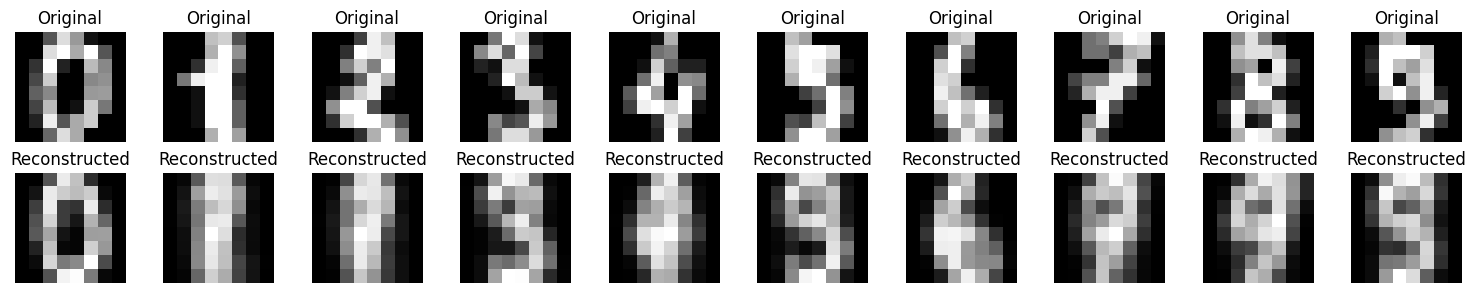

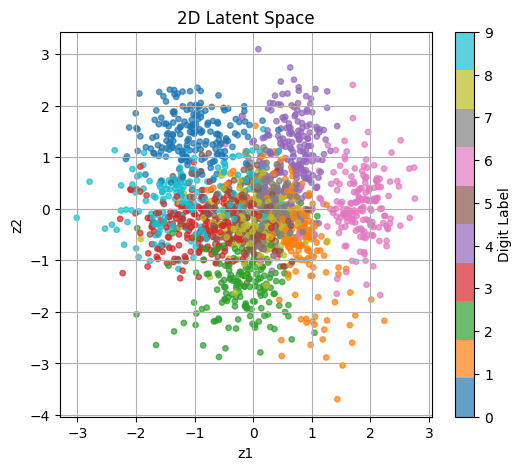

In [19]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, 2)       # Mean of latent distribution
        self.fc_logvar = nn.Linear(32, 2)   # Log variance

        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar, z

# VAE loss
def vae_loss(x_hat, x, mu, logvar):
    recon = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum') #wrong
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

# Train
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    total_loss = 0
    for x_batch, _ in train_loader:
        x_hat, mu, logvar, _ = model(x_batch)
        loss = vae_loss(x_hat, x_batch, mu, logvar)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.2f}")


# Visualize original and reconstructed images
model.eval()
with torch.no_grad():
    x_hat, _, _, z = model(X)


# Show original and reconstructed digits using imshow
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original images
    axes[0, i].imshow(X[i].numpy().reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed images
    axes[1, i].imshow(x_hat[i].numpy().reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")
plt.tight_layout()
plt.show()

# Visualize the 2D latent space
plt.figure(figsize=(6, 5))
z = z.numpy()
plt.scatter(z[:, 0], z[:, 1], c=y.numpy(), cmap='tab10', alpha=0.7, s=15)
plt.colorbar(label='Digit Label')
plt.title("2D Latent Space")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.show()



In [ ]:
X[i]

### Convolutional Autoencoder

What is a convolution?

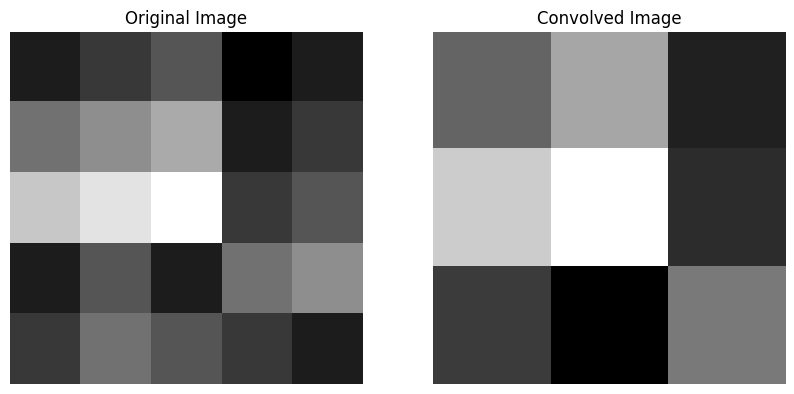

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define a simple 5x5 image
image = np.array([
    [1, 2, 3, 0, 1],
    [4, 5, 6, 1, 2],
    [7, 8, 9, 2, 3],
    [1, 3, 1, 4, 5],
    [2, 4, 3, 2, 1]
])

# Define a simple 3x3 kernel (e.g., edge detection)
kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

# Function to perform convolution (without padding, stride 1)
def convolve2d(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    output = np.zeros((output_height, output_width))
    
    for i in range(output_height):
        for j in range(output_width):
            # Perform element-wise multiplication between kernel and the image region
            region = image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(region * kernel)
    
    return output

# Apply the convolution
convolved_image = convolve2d(image, kernel)

# Plot the original image and the convolved image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image, cmap='gray', interpolation='none')
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(convolved_image, cmap='gray', interpolation='none')
ax2.set_title("Convolved Image")
ax2.axis('off')

plt.show()

### Convolutional Autoencoder
   Uses convolutional layers in both the encoder and decoder to process image data. Convolutional autoencoders are especially effective for image data because they preserve spatial structure.

Epoch 0, Loss: 3.64
Epoch 10, Loss: 1.75
Epoch 20, Loss: 1.62
Epoch 30, Loss: 1.51
Epoch 40, Loss: 1.48
Epoch 50, Loss: 1.45
Epoch 60, Loss: 1.44
Epoch 70, Loss: 1.43
Epoch 80, Loss: 1.44
Epoch 90, Loss: 1.41
Epoch 100, Loss: 1.44
Epoch 110, Loss: 1.43
Epoch 120, Loss: 1.41
Epoch 130, Loss: 1.41


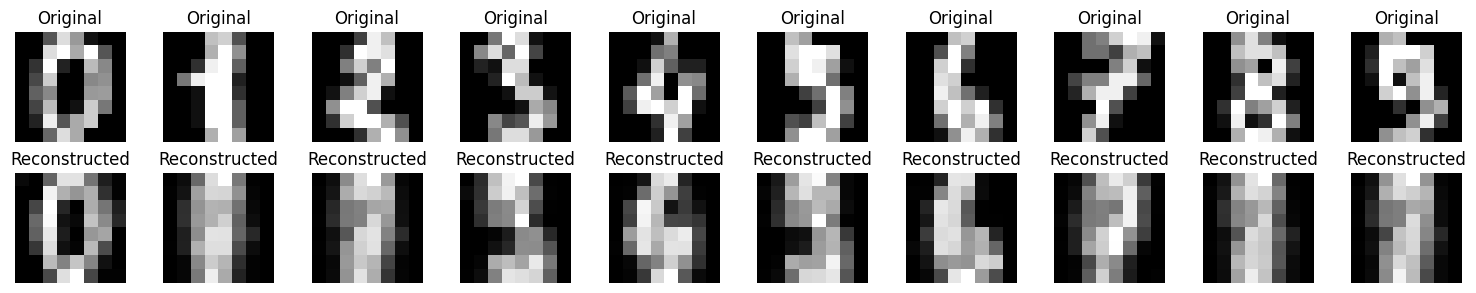

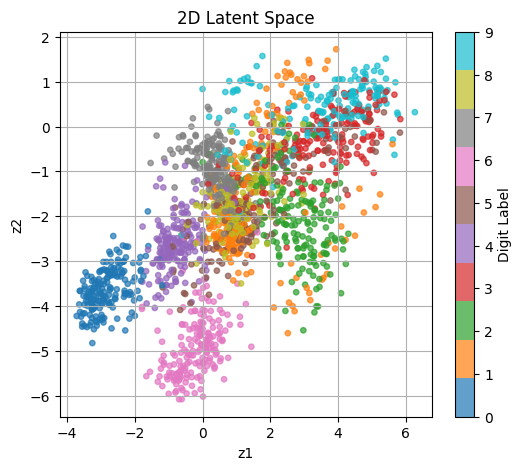

In [13]:
    
torch.manual_seed(42)

# Load and prepare data
digits = load_digits()
X = digits.images  # shape (n_samples, 8, 8)
X = MinMaxScaler().fit_transform(X.reshape(-1, 64)).reshape(-1, 1, 8, 8)  # [0,1] and reshape to (N, C, H, W)

X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)
conv_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define convolutional autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),  # (N, 4, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2),                           # (N, 4, 4, 4)
            nn.Conv2d(4, 8, kernel_size=3, padding=1), # (N, 8, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(2),                           # (N, 8, 2, 2)
            nn.Flatten(),                               # Flatten the feature map (N, 8 * 2 * 2)
            nn.Linear(8 * 2 * 2, 2)                    # Latent space (N, 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 8 * 2 * 2),                   # Latent space to feature map (N, 8 * 2 * 2)
            nn.ReLU(),
            nn.Unflatten(1, (8, 2, 2)),                # Reshape to (N, 8, 2, 2)
            nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2),  # (N, 4, 4, 4)
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=2, stride=2),  # (N, 1, 8, 8)
            nn.Sigmoid()                               # Ensure output is in [0, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    
torch.manual_seed(1)

model = ConvAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(140):
    total_loss = 0
    for x_batch, in conv_loader:
        x_hat, _ = model(x_batch)
        loss = criterion(x_hat, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.2f}")
        
plot_results(model, X, y)

https://arxiv.org/pdf/2201.03898